<font size=8 face="Courier"><b> Latency Directionality Over Eigenvector Layout

This notebook provides a flexible method to plot the latency directionalities ontop of the eigenvector component layout, then randomize the dataset and perform the previous operation to verify it's significance.

image path: "../Human_Hippocampus/data/histology/Hc3.28_hckcr1_chip16835 plated34.2_rec4.2.png"

In [2]:
from matplotlib import pyplot as plt

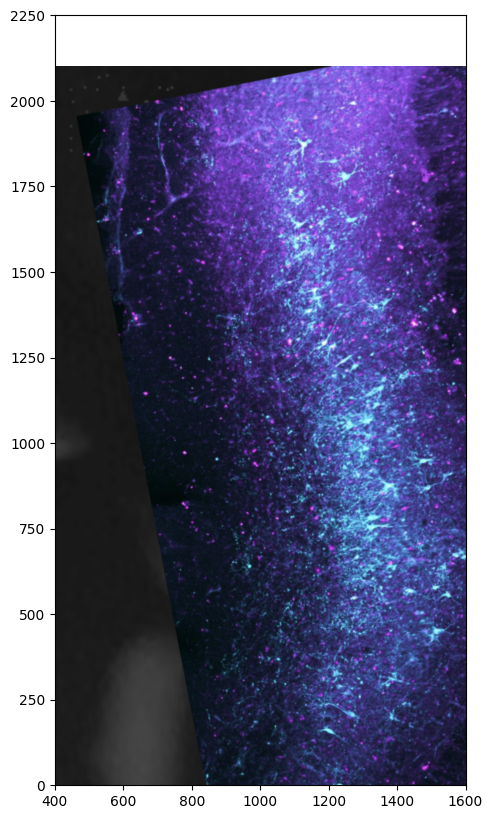

In [5]:
plt.figure(figsize=(14, 10))
img = plt.imread("/workspaces/human_hippocampus/data/histology/ca1a/ca1.png")
plt.xlim(400, 1600)
plt.ylim(0, 2250)
plt.imshow(img,  extent=[0, 3850, 0, 2100] ) #, #interpolation='nearest', aspect='auto')
    

In [29]:
%run "Eigendecomposition_Source_Code.ipynb"

Loading: Eigendecomposition_Source_Code.ipynb...
Done at: 2023/08/22 14:39:53


In [33]:
%run "../code/Basics_Source_Code.ipynb"

	Loading analysis source code...
	Done!


In [149]:
interact_manual(ColorSelect, selection=colors)

interactive(children=(Dropdown(description='selection', options=('viridis', 'plasma', 'inferno', 'magma', 'civ…

<function __main__.ColorSelect(selection)>

# Imports

In [32]:
import pickle
import os
import re
import glob
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
from PIL import Image
from matplotlib.patches import FancyArrow

# <font color="brown">Functions

In [190]:
def loadPickleFile(path):
    global primary_data
    file = open(path, "rb")
    primary_data = pickle.load(file)
    file.close()
    now = datetime.now(Timezone)
    printNow = now.strftime("%Y/%m/%d %H:%M:%S")
    print(f"Done at: {printNow}")

def SelectRandMethod(method, seed, resolution):
    global RandSD
    
    # Options Select
    if method=="Shuffle":
        RandSD = random_shuffle(primary_data, seed)
        
    elif method=="Kenneth Harris":
        RandSD = KennethHarris(primary_data, dt=resolution, seed=seed)
        
    else:
        RandSD = random_rotation(primary_data, seed) 
    
    now = datetime.now(Timezone)
    printNow = now.strftime("%Y/%m/%d %H:%M:%S")
    print(f"Done at: {printNow}")

def find_pairs(sd, sttc_threshold=0.7, num_threshold=200):
    sttc = np.zeros((sd.N, sd.N))
    for i in range(sd.N):
        for j in range(sd.N):
            if i == j: 
                sttc[i][j]=0
            else:
                sttc[i][j] = sd.spike_time_tiling(i, j)

    # Create a mask to filter STTC values above the given threshold
    mask = sttc > sttc_threshold

    # Find the indices of neuron pairs with STTC above the threshold
    neuron_pairs = np.transpose(np.where(mask))
    
    select_pairs = []
    
    for i, neuron_pair in enumerate(neuron_pairs):
        neuron1, neuron2 = neuron_pair
        lates_n1 = sd.latencies_to_index(neuron1)
        lates_num = len(lates_n1[neuron2])
        if lates_num > num_threshold:
            select_pairs.append((neuron1, neuron2))

    return select_pairs

def ArrowsAndEigenvectors(sd, path=None):
    #--------------------------------- Settings ---------------------------------------------------
    selection = 0
    max_ms = 10
    direction_threshold = .65 # og .55
    arrow_color="white"
    #--------------------------------- Settings ---------------------------------------------------
    
    #corr = correlation(sd)
    sttc = get_sttc(sd)
    #Wcorr, Ucorr = eigenvalues_eigenvectors(corr)
    Wsttc, Usttc = eigenvalues_eigenvectors(sttc)
    
    neuron_x = []
    neuron_y = []
    
    for neuron in sd.neuron_data[0].values(): # Plots neurons on a 2-d space, representing their positions on the array
        neuron_x.append(neuron['position'][0])

        neuron_y.append(neuron['position'][1])
        
    #------------------------------- Arrow Code ---------------------------------------------------
    if path == None:
        print("finding pairs...")
        pairs = find_pairs(sd)
        print("find pairs: done")

        lates = []
        for i, neuron_pair in enumerate(pairs): # Get Latencies
            neuron1, neuron2 = neuron_pair
            lates_n1 = sd.latencies_to_index(neuron1)
            lates.append( lates_n1[neuron2] )

        #data = { "pairs_lates":pairs, "latencies":lates }
        print("Get Latencies: done")
        
        lates_short = []
        for latency_dist in lates: # Curate Latencies
            lates_short.append( list(filter(lambda x: x < max_ms and x > -max_ms, latency_dist))  )

        lates_directed = []
        pairs_directed = []

        print("Curate Latencies 1: done")
        for i in range(len(lates_short)): # Curate Latencies
            lates_i = np.array(lates_short[i])
            if len(lates_i) == 0:
                continue
            percent_neg = sum( lates_i<0 )/len(lates_i)
            percent_pos = sum( lates_i>0 )/len(lates_i)

            if percent_neg > direction_threshold or percent_pos > direction_threshold:
                lates_directed.append( lates_i )
                pairs_directed.append( pairs[i] )
        print("Curate Latencies 2: done")
        plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
    
    
        plt.scatter(neuron_x, neuron_y, s=50, c=Usttc[:,selection], cmap = plot_color)
        plt.colorbar(label="Eigen Component Value", shrink=0.6)

        #img = plt.imread("../data/histology/Hc3.28_hckcr1_chip16835 plated34.2_rec4.2.png")
        img = plt.imread("../data/histology/test4.png")
        """plt.xlim(400, 1600)
        plt.ylim(0, 2250)"""

        plt.imshow(img,  extent=[0, 3850, 0, 2100] ) #, #interpolation='nearest', aspect='auto')

        """ax = plt.axes()
        ax.set_facecolor("grey")"""
        #plt.imshow(img,  extent=[0, 3850, 0, 2100] ) #, #interpolation='nearest', aspect='auto')

        # Plot each individual arrow
        for i in range(len(lates_directed)):

            # Get starting and ending arrow based on direction
            is_pos = np.median(lates_directed[i]) > 0
            if is_pos:
                start_i = pairs_directed[i][0]
                end_i = pairs_directed[i][1]
            else:
                start_i = pairs_directed[i][1]
                end_i = pairs_directed[i][0]

            # Add arrow
            arrow = FancyArrow(
                neuron_x[end_i], neuron_y[end_i],
                neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
                length_includes_head=True, head_width=25,
                linewidth=1, color=arrow_color, alpha=0.7, edgecolor=arrow_color, facecolor=arrow_color)
            plt.gca().add_patch(arrow)


        plt.xlabel('um')
        plt.ylabel('um')
        #plt.colorbar(label="Eigen Component Value", shrink=0.6)
        plt.title("Eigenvector & Directionality") # Adding the title
        plt.show()

    else:
        file2 = open(path, "rb")
        data = pickle.load(file2)
        pairs_lates_dict = data["pairs_lates"]
        file2.close()
        
        pairs_lates_directed = pairs_lates_dict
        
        plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
    
    
        plt.scatter(neuron_x, neuron_y, s=50, c=Usttc[:,selection], cmap = plot_color)
        plt.colorbar(label="Eigen Component Value", shrink=0.6)

        #img = plt.imread("../data/histology/Hc3.28_hckcr1_chip16835 plated34.2_rec4.2.png")
        img = plt.imread("../data/histology/test4.png")
        """plt.xlim(400, 1600)
        plt.ylim(0, 2250)"""

        plt.imshow(img,  extent=[0, 3850, 0, 2100] ) #, #interpolation='nearest', aspect='auto')

        """ax = plt.axes()
        ax.set_facecolor("grey")"""
        #plt.imshow(img,  extent=[0, 3850, 0, 2100] ) #, #interpolation='nearest', aspect='auto')
    
        for pair, entries in pairs_lates_directed.items():
            lates_i = np.array(entries)

            if len(lates_i) == 0:
                continue

            percent_neg = np.sum(lates_i < 0) / len(lates_i)
            percent_pos = np.sum(lates_i > 0) / len(lates_i)

            # Check the direction and conditions
            is_pos = np.median(lates_i) > 0
            if is_pos and percent_pos > direction_threshold:
                start_i = pair[0]
                end_i = pair[1]

                arrow_color = "black"
                alpha_upd = 0
                if neuron_y[start_i] < 500 or neuron_y[end_i] < 500:
                    arrow_color = "lime"
                    alpha_upd = 1

                if neuron_x[start_i] < neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
                    arrow_color = "red"
                    alpha_upd = 1

                if neuron_x[start_i] > neuron_x[end_i] and (neuron_y[start_i] > 500 or neuron_y[end_i] > 500):
                    arrow_color = "yellow"
                    alpha_upd = 1

                arrow = FancyArrow(
                    neuron_x[end_i], neuron_y[end_i],
                    neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
                    length_includes_head=True, head_width=25,
                    linewidth=1, color=arrow_color, alpha=alpha_upd, edgecolor=arrow_color, facecolor=arrow_color)
                plt.gca().add_patch(arrow)
            
        plt.xlabel('um')
        plt.ylabel('um')
        #plt.colorbar(label="Eigen Component Value", shrink=0.6)
        plt.title("Eigenvector & Directionality") # Adding the title
        plt.show()
        
    #------------------------------- Arrow Code ---------------------------------------------------
    
    

    # Plot each individual arrow
    for i in range(len(lates_directed)):

        # Get starting and ending arrow based on direction
        is_pos = np.median(lates_directed[i]) > 0
        if is_pos:
            start_i = pairs_directed[i][0]
            end_i = pairs_directed[i][1]
        else:
            start_i = pairs_directed[i][1]
            end_i = pairs_directed[i][0]
        
        # Add arrow
        arrow = FancyArrow(
            neuron_x[end_i], neuron_y[end_i],
            neuron_x[start_i] - neuron_x[end_i], neuron_y[start_i] - neuron_y[end_i],
            length_includes_head=True, head_width=25,
            linewidth=1, color=arrow_color, alpha=0.7, edgecolor=arrow_color, facecolor=arrow_color)
        plt.gca().add_patch(arrow)


    

# Analysis

## Primary Data

Run the cell bellow to load pickled data into the file's environment 

In [109]:
files = {"5-10-23 S1":"/home/jovyan/work/Human_Hippocampus/5-10-23s1-CutData.pkl", 
         "Unperturbed CA1":"/home/jovyan/work/Human_Hippocampus/StitchedDataUpdated.pkl"}

In [164]:
interact_manual(loadPickleFile, path=files)

interactive(children=(Dropdown(description='path', options={'5-10-23 S1': '/home/jovyan/work/Human_Hippocampus…

<function __main__.loadPickleFile(path)>

### Correlation & STTC

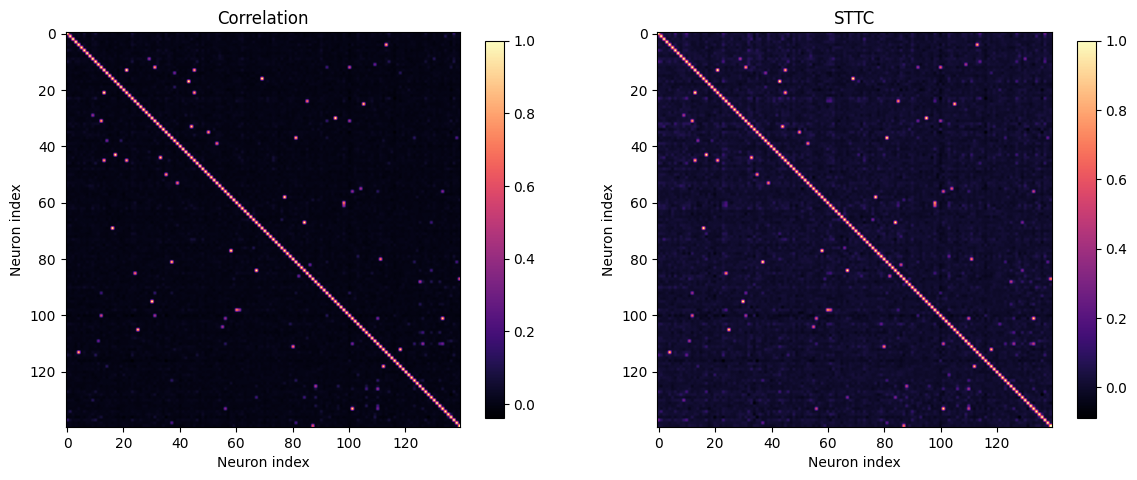

In [112]:
primCorr = correlation(primary_data)
primSTTC = get_sttc(primary_data)

corrMethPlots(primCorr, primSTTC)

### Plot Data Raster

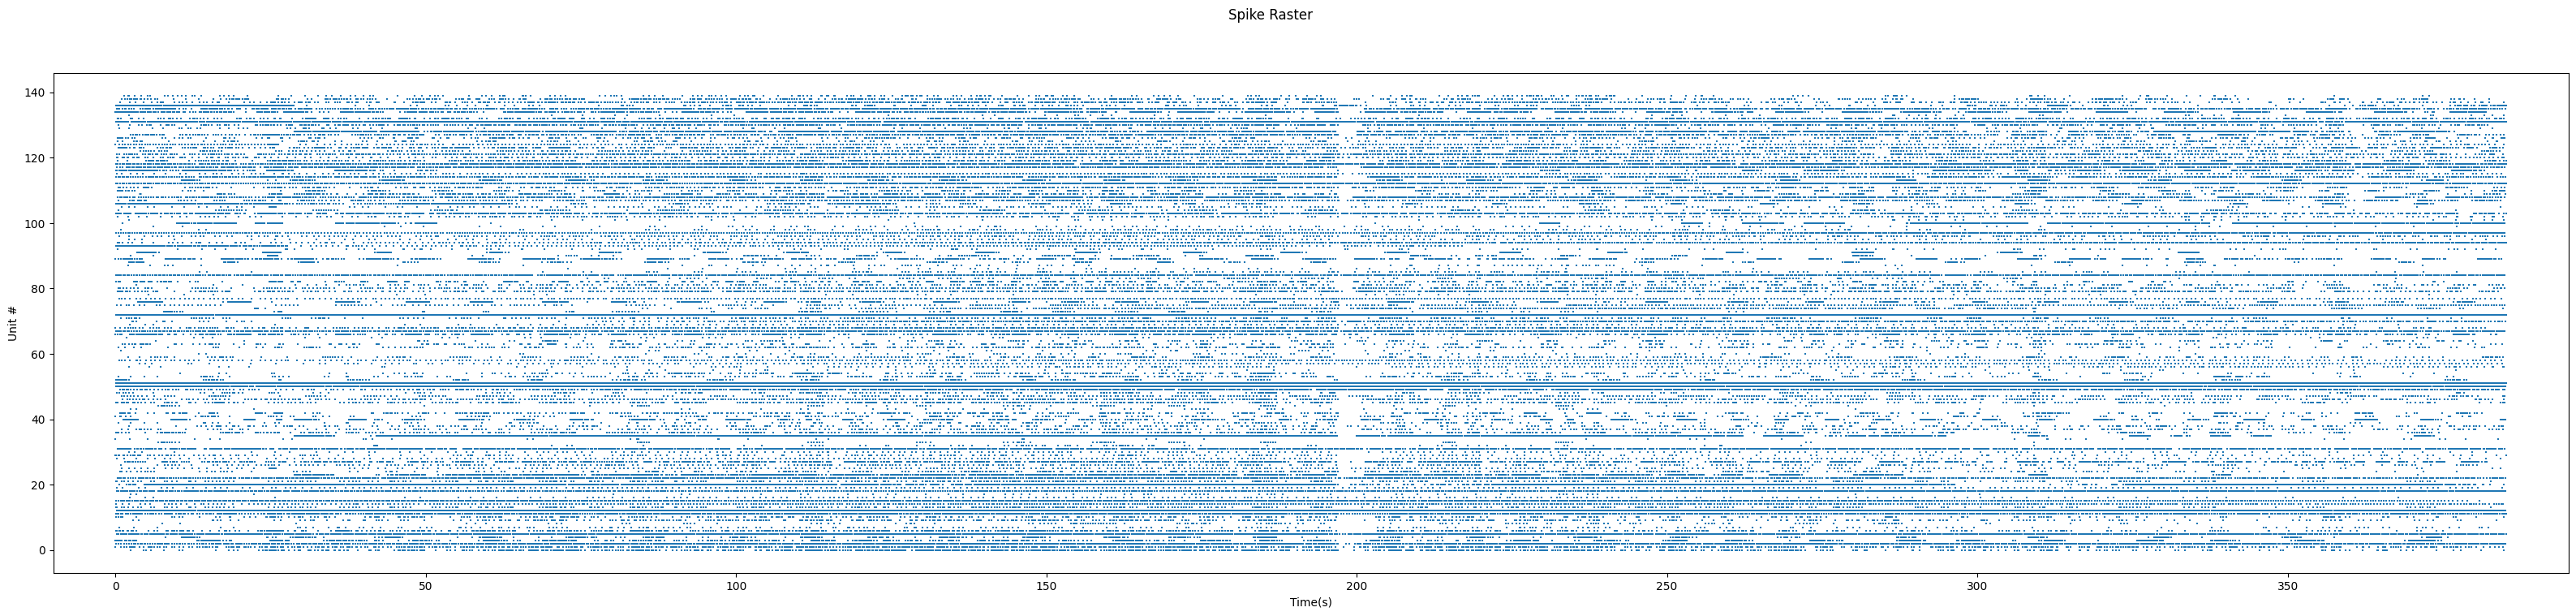

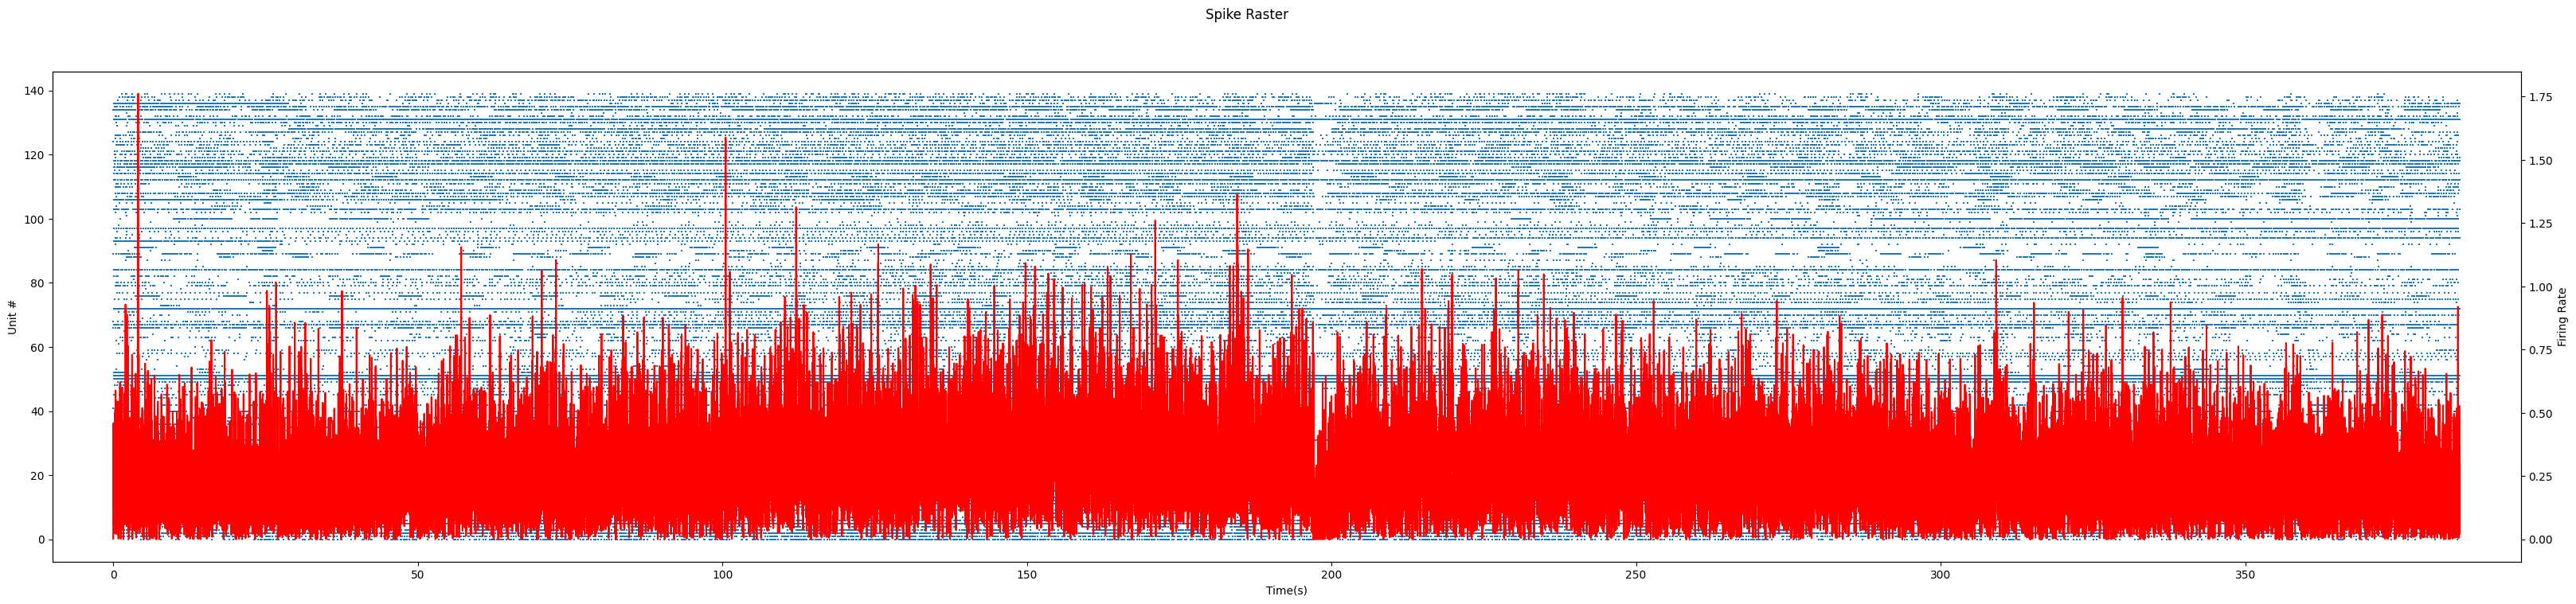

In [30]:
plot_raster(primary_data, l1=-10, l2=False, xsize=40, ysize=8, analize=False)
plot_raster(primary_data, l1=-10, l2=False, xsize=40, ysize=8, analize=True)

### <font color="green">Main Function

Run the cell bellow to print arrows ontop of eigenvector Layout, this may take a while to run

/tmp/ipykernel_2423539/2787310408.py:69: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values(): # Plots neurons on a 2-d space, representing their positions on the array
/tmp/ipykernel_2423539/2787310408.py:206: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(


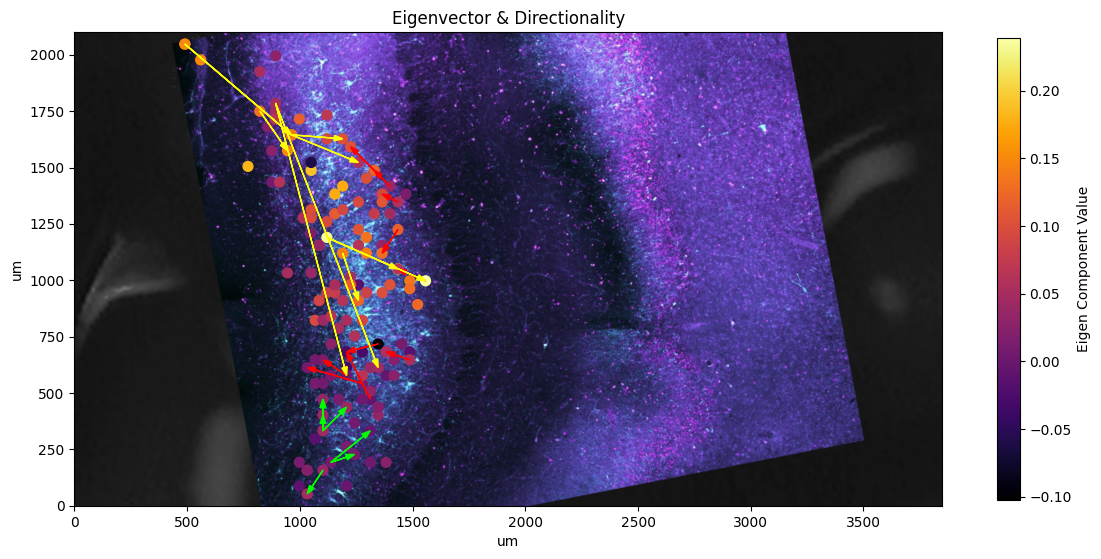

UnboundLocalError: local variable 'lates_directed' referenced before assignment

In [191]:
ArrowsAndEigenvectors(primary_data, path="/home/jovyan/work/Human_Hippocampus/Pairs_and_Lates_Directed.pkl")

## <font color="red">Randomize Data

Run the cell bellow to randomize the primarily loaded data, select random method (preferred is Kenneth Harris) and seed.


<b>Note:</b> if you are running Kenneth Harris Randomization it is recomended to set the resolution to 1. You do not need to worry about fiddling with the resolution for the two other randomizing methods. 

In [93]:
interact_manual(SelectRandMethod, method=randMethods, seed=(1,10000), resolution=(0.001,1,0.001)) 

interactive(children=(Dropdown(description='method', options=('Rotation', 'Shuffle', 'Kenneth Harris'), value=…

<function __main__.SelectRandMethod(method, seed, resolution)>

### Compare Correaltions

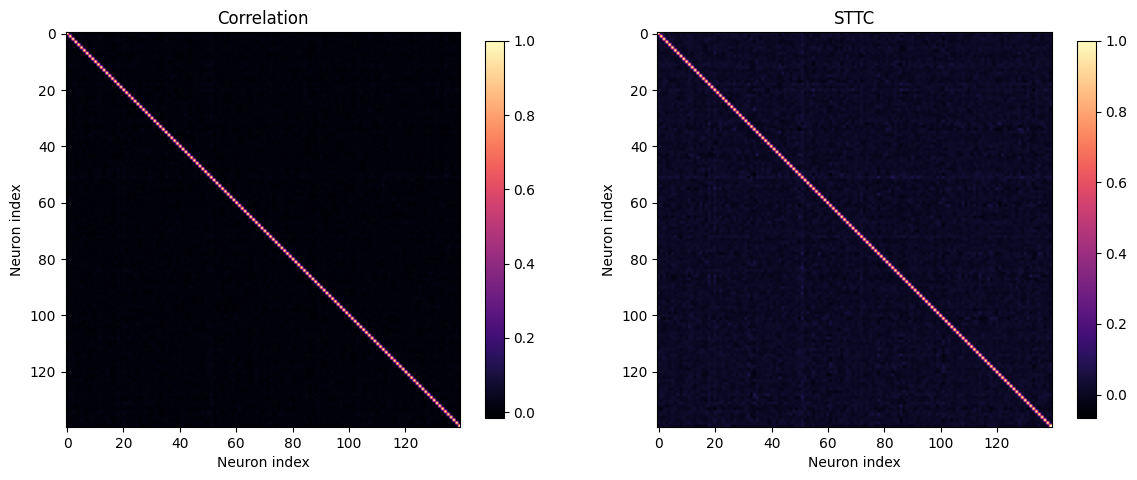

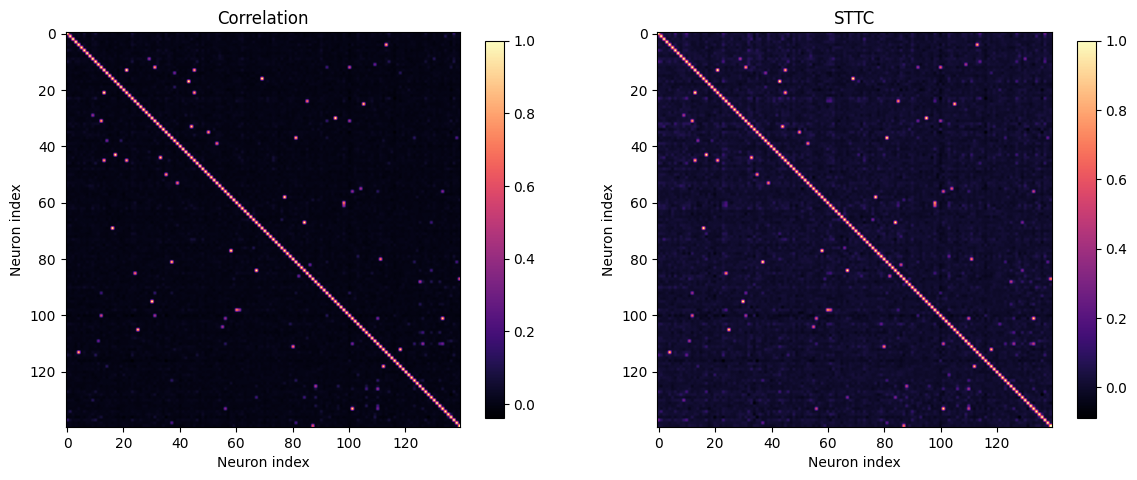

In [94]:
randCorr = correlation(RandSD)
randSTTC = get_sttc(RandSD)

corrMethPlots(randCorr, randSTTC)
corrMethPlots(primCorr, primSTTC)

### Compare Rasters

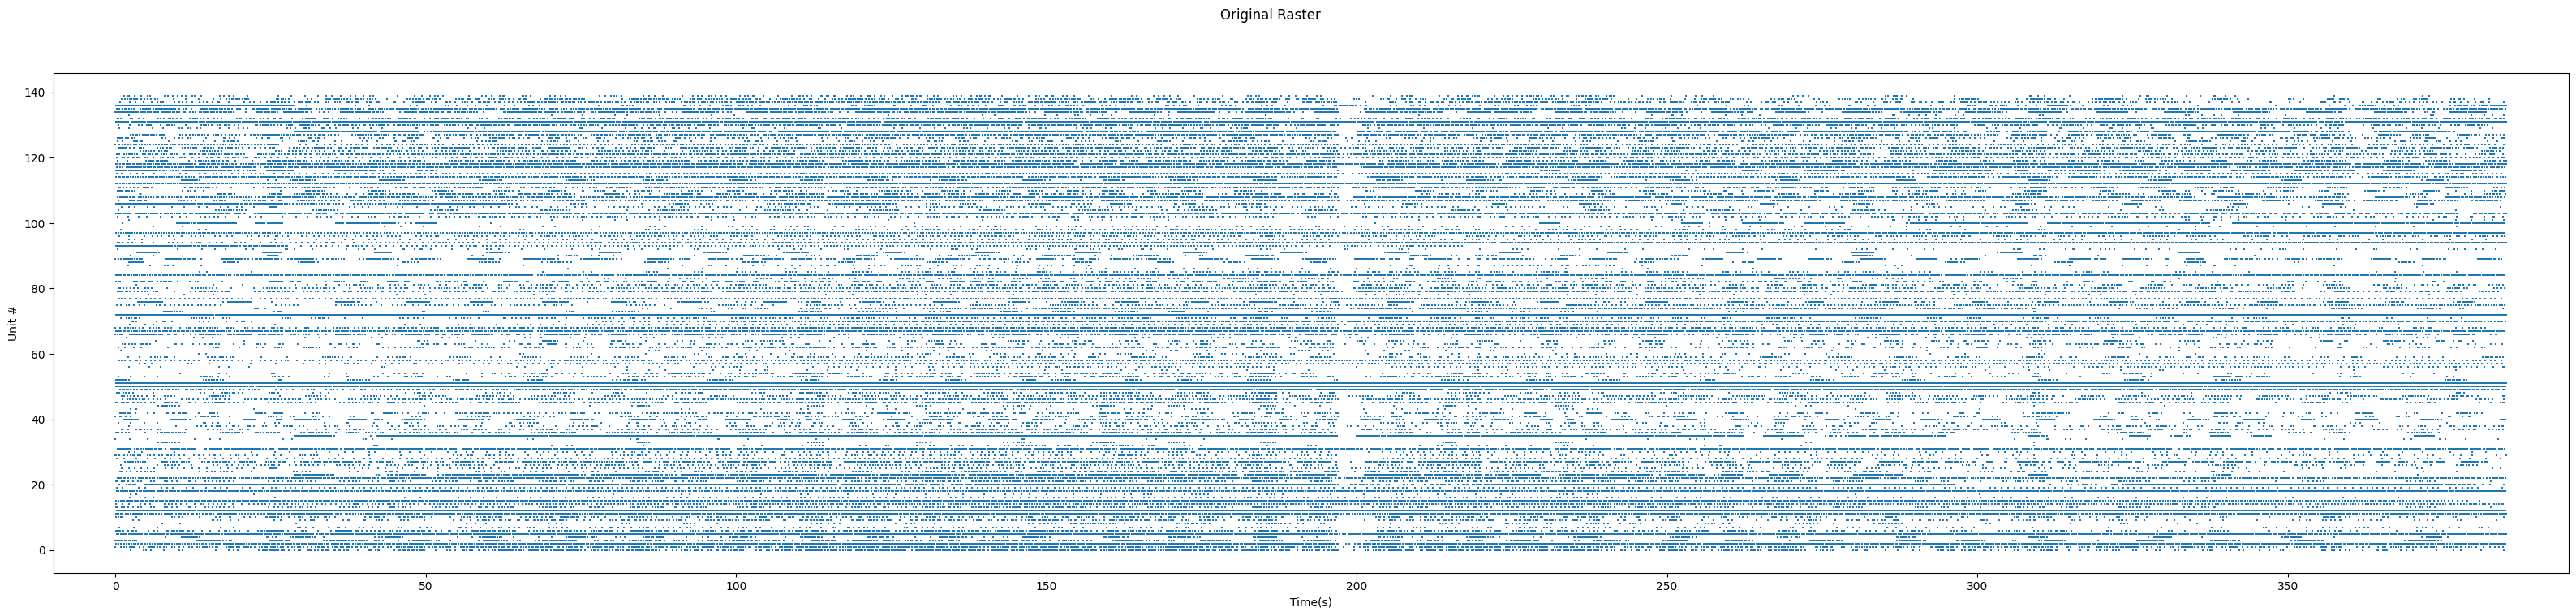

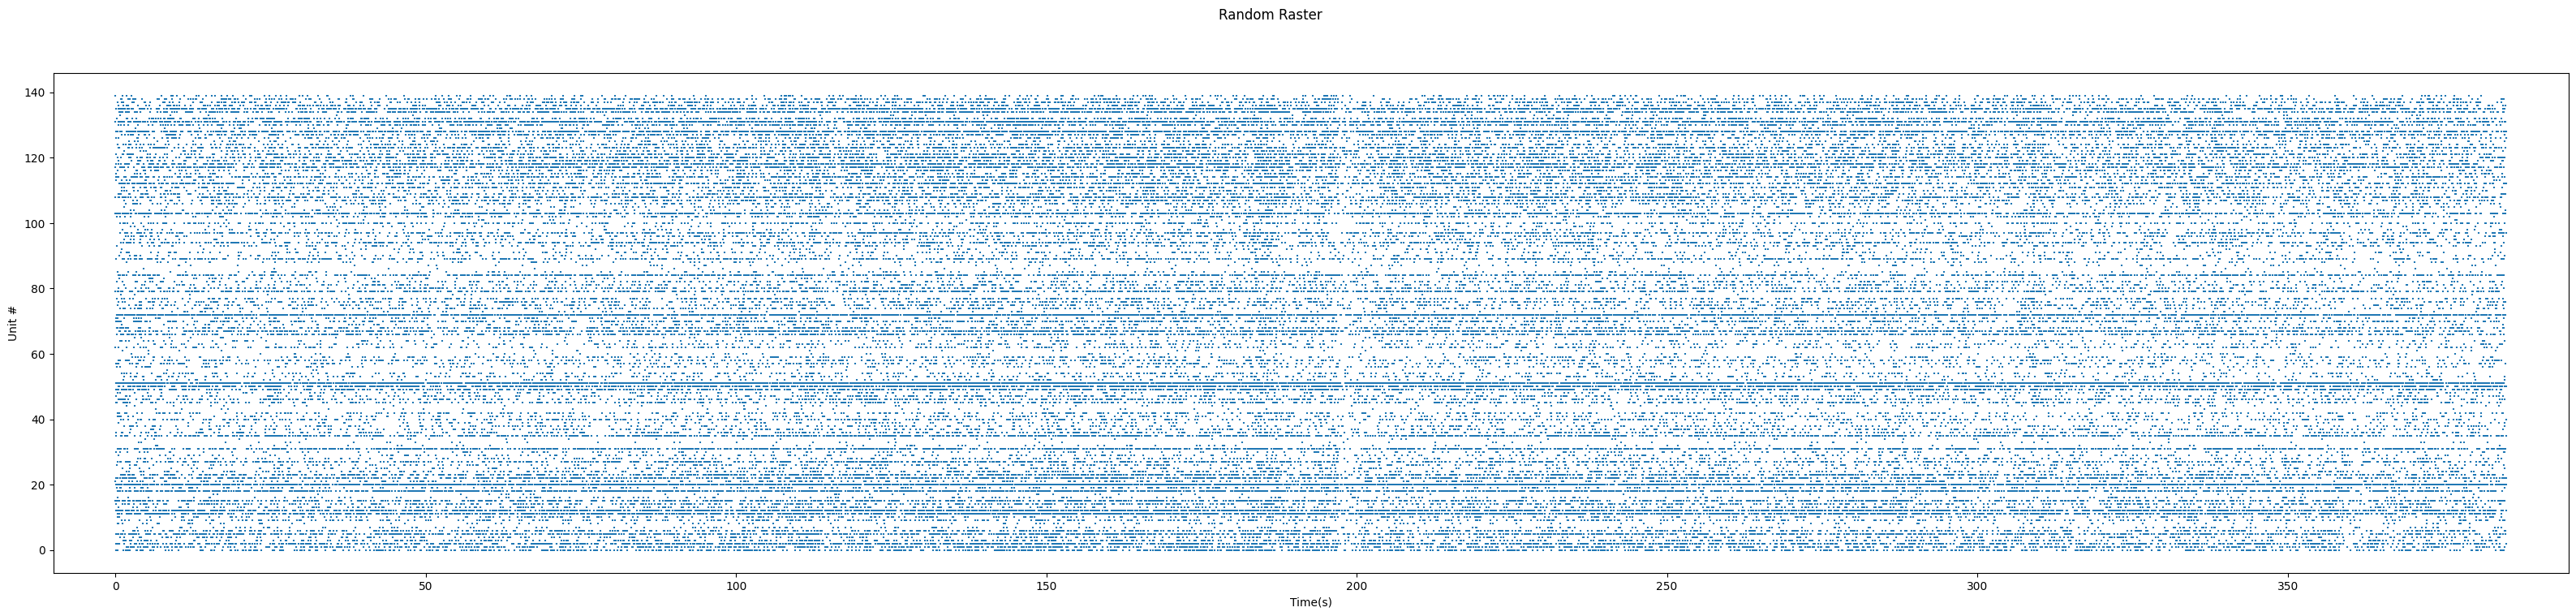

In [97]:
plot_raster(primary_data, title="Original Raster", l1=-10, l2=False, xsize=40, ysize=8, analize=False)
plot_raster(RandSD, title="Random Raster", l1=-10, l2=False, xsize=40, ysize=8, analize=False)

### <font color="green">Main Function

/tmp/ipykernel_2423539/1571098452.py:68: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values(): # Plots neurons on a 2-d space, representing their positions on the array


finding pairs...
find pairs: done
Get Latencies: done
Curate Latencies 1: done
Curate Latencies 2: done


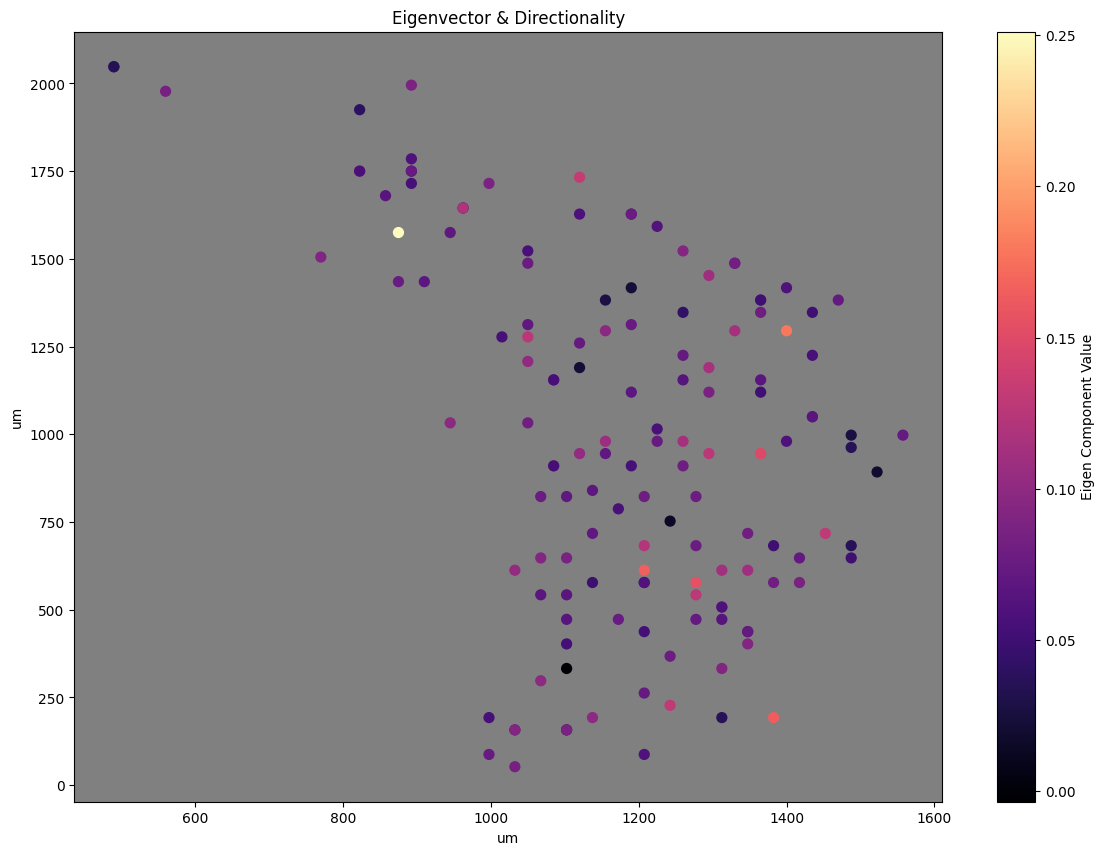

In [98]:
ArrowsAndEigenvectors(RandSD)